# Objetivo



1.  Gerar artefatos de IA (modelo, transformador e normalizador);

2.   Carregar os artefatos, visando a reutilização sem necessidade de retreinar o modelo;
3. Avaliar o desempenho do modelo por meio de métricas matemáticas;
4. Simular o processo de previsão de preço via API Rest, por requisições POST, usando os artefatos carregados;
5. Visualização gráfica do pipeline de dados.



In [27]:
!pip install scikit-learn==1.3.2  # Machine Learning e funções de pré-processamento de dados.

In [29]:
## Importe bibliotecas relevantes para processamento e visualização de dados

import numpy as np                # álgebra linear
import pandas as pd               # processamento de dados, I/O de arquivo de conjunto de dados (por exemplo, pd.read_csv)
import matplotlib.pyplot as plt   # visualização de dados e plotagem gráfica
import seaborn as sns             # para visualizar distribuições aleatórias
%matplotlib inline

##  Adicione bibliotecas adicionais para preparar e executar o modelo

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesRegressor

pd.options.display.float_format = '{:.4f}'.format

import warnings                    # para lidar com mensagens de aviso
warnings.filterwarnings('ignore')

In [30]:
## Tenha baixado préviamente o conjunto de dados e feito o upload para o google colab
df = pd.read_csv('machinetable.csv')
df.head()

,id,created_at,updated_at,is_active,price,brand,url,crawl_date,year_reference,month_reference,...,model,year_fabrication,year_model,title,mileage,gear,fuel,bodywork,city,state
0,69c52d79-667f-4d7b-800e-e20f06ebc3c2,2025-01-18 23:14:24.230645-03:00,2025-01-18 23:14:24.230651-03:00,True,7699000.0000,HONDA,https://www.usadosbr.com//carros-e-utilitarios...,2025-01-18 23:14:24.230660-03:00,2025,1,...,CITY,NaN,2017,HONDA CITY,80000.0000,CVT,FLEX,SEDAN,CUIABA,MT
1,f0f2b352-757c-40e6-bcaf-de1192383d9c,2025-01-18 23:14:27.002594-03:00,2025-01-18 23:14:27.002601-03:00,True,6999000.0000,CHEVROLET,https://www.usadosbr.com//carros-e-utilitarios...,2025-01-18 23:14:27.002613-03:00,2025,1,...,ONIX,NaN,2023,CHEVROLET ONIX,69902.0000,MANUAL,FLEX,HATCH,GOIANIA,GO
2,8e97ce37-b3e6-4db1-8a65-d603ae1ac62c,2025-01-18 23:16:30.360775-03:00,2025-01-18 23:16:30.360782-03:00,True,6999000.0000,HYUNDAI,https://www.usadosbr.com//carros-e-utilitarios...,2025-01-18 23:16:30.360794-03:00,2025,1,...,HB20,NaN,2022,HYUNDAI HB20,44744.0000,MANUAL,FLEX,HATCH,SAO PAULO,SP
3,a4c59228-626e-406f-9036-d34360f8ffd5,2025-01-18 23:14:22.416528-03:00,2025-01-18 23:14:22.416546-03:00,True,5250000.0000,FORD,https://www.usadosbr.com//carros-e-utilitarios...,2025-01-18 23:14:22.416561-03:00,2025,1,...,ECOSPORT,NaN,2013,FORD ECOSPORT,228000.0000,MANUAL,FLEX,SUV,IBIUNA,SP
4,185d7281-7322-4d28-a11e-b962d692d532,2025-01-18 23:14:22.416587-03:00,2025-01-18 23:14:22.416593-03:00,True,17990000.0000,CHEVROLET,https://www.usadosbr.com//carros-e-utilitarios...,2025-01-18 23:14:22.416602-03:00,2025,1,...,S10,NaN,2017,CHEVROLET S10,141000.0000,AUTOMATICO,DIESEL,PICAPE CABINE DUPLA,GOIANIA,GO


# Preparando os dados para treinamento do modelo

In [31]:
# Contar valores ausentes por coluna
missing_values = df.isna().sum()

# Mostrar valores ausentes para cada coluna
print(missing_values)

id                     0
created_at             0
updated_at             0
is_active              0
price                  0
brand                  0
url                    0
crawl_date             0
year_reference         0
month_reference        0
description         4846
code_model             0
model                  0
year_fabrication    4846
year_model             0
title                  0
mileage                5
gear                   0
fuel                   0
bodywork               0
city                   0
state                  0
dtype: int64


In [32]:
# Descartar registros onde a coluna 'mileage' está ausente
df = df.dropna(subset=['mileage'])

# Confirmar a remoção
print(f"Número Total de Registros após descartar ausentes em 'mileage': {df.shape[0]}")

Número Total de Registros após descartar ausentes em 'mileage': 4841


In [33]:
## descartando as features irrelevantes (colunas)
df.drop(["id", "created_at", "updated_at", "is_active", "crawl_date", "url",
         "year_reference", "month_reference", "code_model", "year_fabrication",
         "description", "title"], axis=1, inplace=True)

## verificando as features após descartar recursos indesejados
df.columns

Index(['price', 'brand', 'model', 'year_model', 'mileage', 'gear', 'fuel',
       'bodywork', 'city', 'state'],
      dtype='object')

In [34]:
## Criando novas features para deixar o modelo mais preciso

import datetime

# Idade do carro
current_year = datetime.datetime.now().year
df['age_years'] = current_year - df['year_model']

# diferença entre o preço de um veículo e o preço médio dos veículos com o mesmo modelo e ano modelo
df['price_deviation'] = df['price'] - df.groupby(['model', 'year_model'])['price'].transform('mean')

# Preço médio por marca
brand_avg = df.groupby('brand')['price'].transform('mean')
df['brand_avg_price'] = brand_avg

# Preço médio por estado
state_avg = df.groupby('state')['price'].transform('mean')
df['state_avg_price'] = state_avg

# Preço médio por cidade
city_avg = df.groupby('city')['price'].transform('mean')
df['city_avg_price'] = city_avg

# Marcas de luxo (ajuste conforme necessário)
luxury_brands = ['PORSCHE', 'JAGUAR', 'MERCEDES-BENZ', 'BMW', 'LAND ROVER', 'VOLVO']
df['is_luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

In [8]:
# Cálculo do IQR para detectar outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Limites inferior e superior
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrando os outliers
df_clean = df[(df['price'] >= lower_limit) & (df['price'] <= upper_limit)]

# Verificando os resultados
print(f"Dados originais: {len(df)} registros")
print(f"Dados após remoção dos outliers: {len(df_clean)} registros")

# Exibindo as estatísticas descritivas do dataframe sem outliers
print(df_clean['price'].describe())

Dados originais: 4841 registros
Dados após remoção dos outliers: 4670 registros
count       4670.0000
mean     9834804.9550
std      2884612.4249
min      1050000.0000
25%      7399000.0000
50%      9229000.0000
75%     11999000.0000
max     19355000.0000
Name: price, dtype: float64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4841 entries, 0 to 4845
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            4841 non-null   float64
 1   brand            4841 non-null   object 
 2   model            4841 non-null   object 
 3   year_model       4841 non-null   int64  
 4   mileage          4841 non-null   float64
 5   gear             4841 non-null   object 
 6   fuel             4841 non-null   object 
 7   bodywork         4841 non-null   object 
 8   city             4841 non-null   object 
 9   state            4841 non-null   object 
 10  age_years        4841 non-null   int64  
 11  price_deviation  4841 non-null   float64
 12  brand_avg_price  4841 non-null   float64
 13  state_avg_price  4841 non-null   float64
 14  city_avg_price   4841 non-null   float64
 15  is_luxury_brand  4841 non-null   int64  
dtypes: float64(6), int64(3), object(7)
memory usage: 642.9+ KB


# Gerando os Artefatos

In [10]:
import pickle

In [11]:
# Supondo que 'df' já tenha as novas features criadas.

# 1. Identificar automaticamente as colunas categóricas e numéricas
categorical_columns = df.select_dtypes(exclude=["int", "float"]).columns.tolist()
numerical_columns = df.select_dtypes(include=["int", "float"]).columns.tolist()

# Remover 'price' (variável alvo) das colunas numéricas
numerical_columns.remove('price')

# Separar X e y
X = df.drop(columns=["price"])
y = df["price"]


In [12]:
# 2. Aplicar o OneHotEncoder nas colunas categóricas
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = ohe.fit_transform(X[categorical_columns])

# Criar DataFrame com os dados codificados
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_columns), index=df.index)

# Concatenar as colunas codificadas com as numéricas
X = X.drop(columns=categorical_columns)
X = pd.concat([X, encoded_df], axis=1)


In [13]:
# 3. Aplicar o StandardScaler nas colunas numéricas (incluindo as novas features numéricas)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[numerical_columns])

# Criar um DataFrame com os dados escalonados
scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns, index=df.index)

# Substituir as colunas numéricas originais pelos valores escalonados
X[numerical_columns] = scaled_df

In [14]:
# 4. Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
# 5. Treinar o modelo
randfor_model = RandomForestRegressor()
randfor_model.fit(X_train, y_train)

RandomForestRegressor()

In [16]:
# 6. Salvar os artefatos
with open('onehotencoder.pkl', 'wb') as file:
    pickle.dump(ohe, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('randfor_model.pkl', 'wb') as file:
    pickle.dump(randfor_model, file)

print("Artefatos salvos com sucesso!")

Artefatos salvos com sucesso!


In [17]:
# Carregar os artefatos salvos
with open('onehotencoder.pkl', 'rb') as file:
    ohe = pickle.load(file)

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('randfor_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Avaliação do modelo

In [18]:
## Função de avaliação de modelo
def model_eval(model, X_test, y_test):  # Pass X_test and y_test to the function
    y_pred = model.predict(X_test)  # Make predictions using the model
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    # Create a DataFrame with the calculated metrics
    preds = pd.DataFrame({
        "Nome_Modelo": [type(model).__name__],  # Use model's class name for model name
        "Valor_R2": [r2],
        "Valor_adj_R2": [adj_r2],
        "MSE": [mse],
        "RMSE": [rmse],
        "MAE": [mae]
    })

    return preds.sort_values(by="Valor_R2", ascending=False)

## Avaliação do modelo
model_eval(model, X_test, y_test)


,Nome_Modelo,Valor_R2,Valor_adj_R2,MSE,RMSE,MAE
0,RandomForestRegressor,0.8381,0.7316,3702342134834.7036,1924147.1188,447837.0802


# Simulação API Rest



* Como usar o modelo treinado através de requisições POST? representadas por input_jon.



In [23]:
import pandas as pd
import numpy as np
import datetime

# Função para processar input_json e gerar previsão
def predict_price(input_json, model, df, ohe, scaler):
    # 1. Adicionar features calculadas
    current_year = datetime.datetime.now().year
    input_json['age_years'] = current_year - input_json['year_model']

    # Calcular médias dinâmicas com base nos dados
    input_json['brand_avg_price'] = input_json['brand'].apply(lambda x: df[df['brand'] == x]['price'].mean())
    input_json['state_avg_price'] = input_json['state'].apply(lambda x: df[df['state'] == x]['price'].mean())
    input_json['city_avg_price'] = input_json['city'].apply(lambda x: df[df['city'] == x]['price'].mean())

    # Cálculo do price_deviation: baseado no model e year_model
    def calculate_price_deviation(row):
        group = df[(df['model'] == row['model']) & (df['year_model'] == row['year_model'])]
        group_avg_price = group['price'].mean() if not group.empty else 0
        return group_avg_price - row['brand_avg_price']

    input_json['price_deviation'] = input_json.apply(calculate_price_deviation, axis=1)

    # Identificar marcas de luxo
    input_json['is_luxury_brand'] = input_json['brand'].apply(lambda x: 1 if x in ['AUDI', 'BMW', 'MERCEDES', 'PORSCHE'] else 0)

    # 2. Pré-processar input_json
    categorical_columns = ['brand', 'model', 'gear', 'fuel', 'bodywork', 'city', 'state']
    numerical_columns = ['year_model', 'mileage', 'age_years', 'price_deviation',
                         'brand_avg_price', 'state_avg_price', 'city_avg_price', 'is_luxury_brand']

    # a. Aplicar o OneHotEncoder nas colunas categóricas
    encoded_categorical = ohe.transform(input_json[categorical_columns])
    encoded_categorical_df = pd.DataFrame(
        encoded_categorical,
        columns=ohe.get_feature_names_out(categorical_columns),
        index=input_json.index
    )

    # b. Normalizar as colunas numéricas
    normalized_numeric = scaler.transform(input_json[numerical_columns])
    normalized_numeric_df = pd.DataFrame(
        normalized_numeric,
        columns=numerical_columns,
        index=input_json.index
    )

    # c. Concatenar as colunas normalizadas e codificadas
    final_input_df = pd.concat([normalized_numeric_df, encoded_categorical_df], axis=1)

    # d. Garantir que o DataFrame tenha a mesma estrutura do X_test
    missing_columns = set(X_test.columns) - set(final_input_df.columns)
    for col in missing_columns:
        final_input_df[col] = 0

    final_input_df = final_input_df[X_test.columns]

    # 3. Fazer a previsão com o modelo carregado
    prediction = model.predict(final_input_df)[0]

    # 4. Formatando o valor da previsão em estilo monetário brasileiro
    formatted_prediction = str(int(prediction))  # Converte para string e remove decimais

    if len(formatted_prediction) == 7:  # Caso o número tenha 7 dígitos (2 antes do ponto)
        formatted_prediction = formatted_prediction[:2] + "." + formatted_prediction[2:5] + "," + formatted_prediction[5:]
    elif len(formatted_prediction) == 8:  # Caso o número tenha 8 dígitos (3 antes do ponto)
        formatted_prediction = formatted_prediction[:3] + "." + formatted_prediction[3:6] + "," + formatted_prediction[6:]
    else:
        formatted_prediction = formatted_prediction # Mantém o formato original se não for 7 ou 8 dígitos

    return formatted_prediction

# Exemplo de uso
input_json = pd.DataFrame([{
    "brand": "HYUNDAI",
    "model": "HB20",
    "year_model": 2025,
    "mileage": 45000,
    "gear": "AUTOMATICO",
    "fuel": "FLEX",
    "bodywork": "SEDAN",
    "city": "SAO PAULO",
    "state": "SP"
}])

previsao = predict_price(input_json, model, df, ohe, scaler)
print(f"Previsão para o veículo: R$ {previsao}")


Previsão para o veículo: R$ 88.113,30


## Diagrama do pipeline de dados

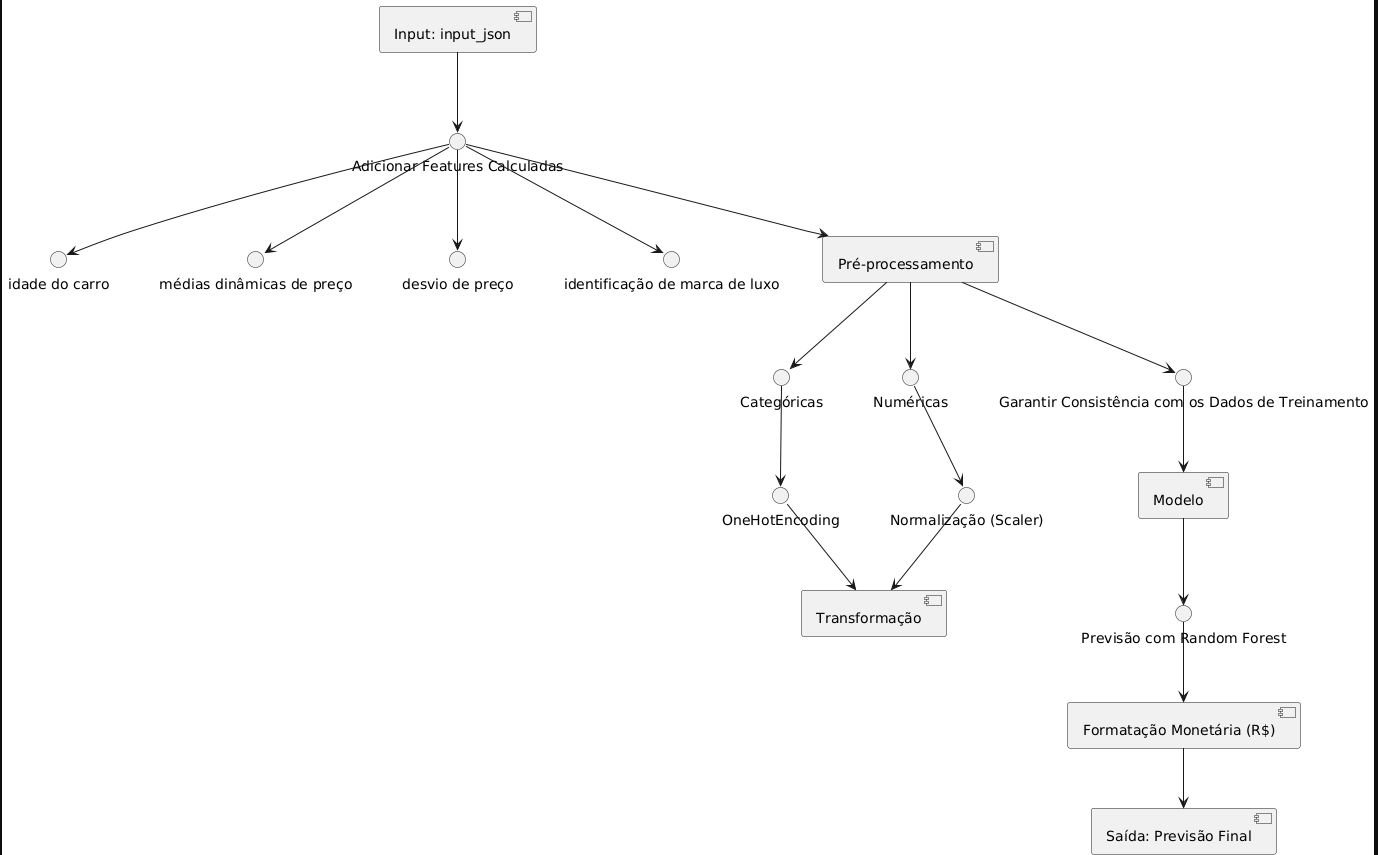